# Visualisation of the Prediction Depth of CIFAR-10

### - Read output from `get_pd`

In [15]:
import os
import json

def read_il_files(directory: str) -> tuple[list[str], list[dict]]:
    """
    This function is going to read all .pkl file from a give directory
    @param directory: ..
    @return: ([file name list], [dict list])
    """
    il_dict_list = []
    file_list = os.listdir(directory)
    json_files = [file for file in file_list if file.endswith("train_avg.json")]

    for json_file in json_files:
        file_path = os.path.join(directory, json_file)
        with open(file_path, "rb") as f:
            dict_load = json.load(f)
            int_key_dict = {}
            for key, value in dict_load.items():
                int_key_dict[int(key)] = value
            il_dict_list.append(int_key_dict)


    return json_files, il_dict_list


_, il_dict = read_il_files(os.path.join(os.getcwd(), "il_results", "avg"))
il_dict = il_dict[0]

### - Link `il_dict` to `cifar10` dataset

In [16]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import PILToTensor
import matplotlib.pyplot as plt

class CIFAR10PD(CIFAR10):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CIFAR10PD, self).__init__(root, train, transform, target_transform, download)

    def __getitem__(self, index):
        # to get (img, target), index
        img, target = super(CIFAR10PD, self).__getitem__(index)
        return PILToTensor()(img), target, index
trainset = CIFAR10PD('./', train=False, download=True)
testset = CIFAR10PD('./', train=True, download=True)

dataloader_train = DataLoader(trainset, batch_size=1, shuffle=False)
dataloader_test = DataLoader(testset, batch_size=1, shuffle=False)

CIFAR_dict = {}

for imgs, targets, indexes in dataloader_train:
    for img, target, index in zip(imgs, targets, indexes):
        CIFAR_dict[index.item()] = (img, target)

Files already downloaded and verified
Files already downloaded and verified


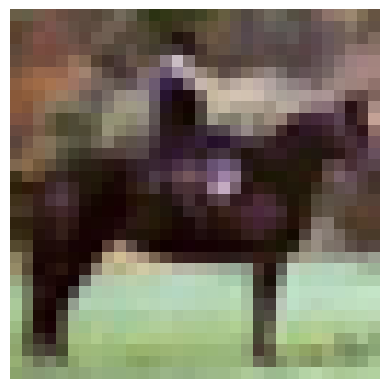

In [17]:
image_np = CIFAR_dict[1198][0].numpy()
image_np = image_np.transpose(1, 2, 0)

# Plot the CIFAR-10 image
plt.imshow(image_np)
plt.axis('off')
plt.show()

### - split the unlearned images and learned images

In [18]:
learned_il_dict = {}
unlearned_il_dict = {}

for index, score in il_dict.items():
    if score == -1:
        unlearned_il_dict[index] = -1
    else:
        learned_il_dict[index] = score

def imgHardnessLink(img_dict: dict, hardness_dict:dict) -> dict:
    """
    This function gives each image its hardness score
    @param img_dict: dictionary of image in the format of {index : (img, target)}
    @param pd_dict: dictionary of image in the format of {index : PD score}
    @return: dictionary of {img : (target, PD score)}
    """

    img_hardness_dict = {}
    for index in (set(hardness_dict.keys()).intersection(set(img_dict.keys()))):
        img_hardness_dict[img_dict[index][0]] = (img_dict[index][1], hardness_dict[index], index)
    return img_hardness_dict


learned_img_IL_dict = imgHardnessLink(CIFAR_dict, learned_il_dict)
unlearned_il_dict = imgHardnessLink(CIFAR_dict, unlearned_il_dict)

### -Visualisation

Score: 1


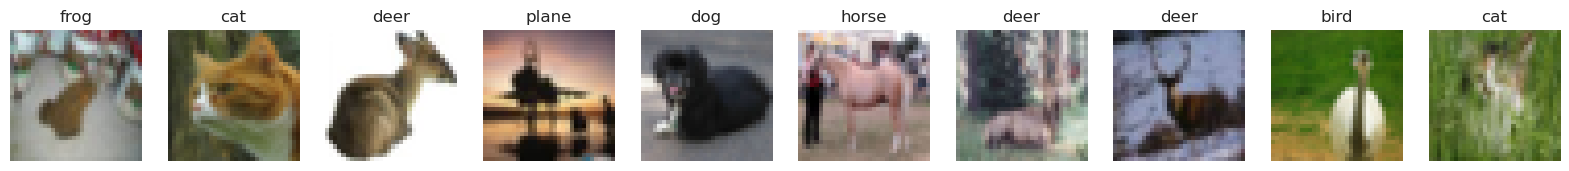

Score: 2


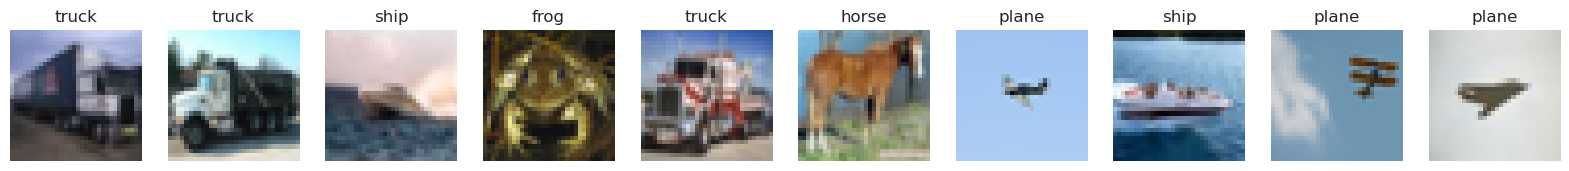

Score: 3


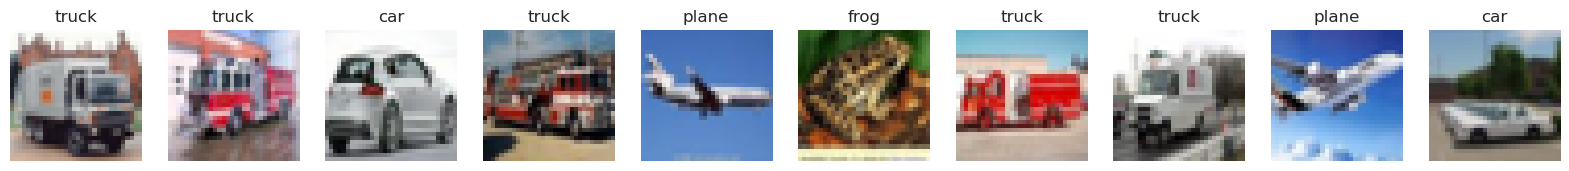

Score: 4


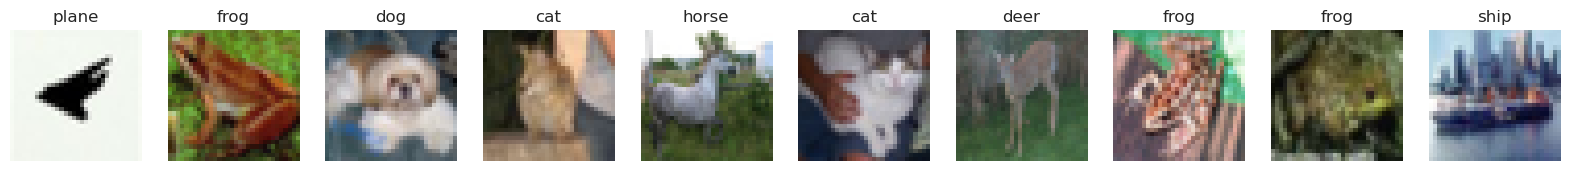

Score: 5


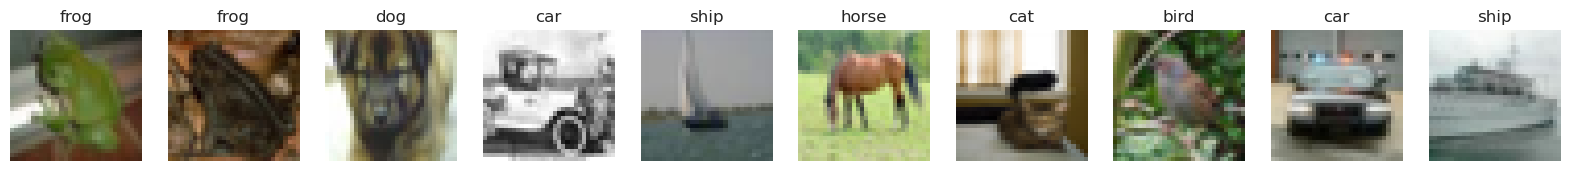

Score: 6


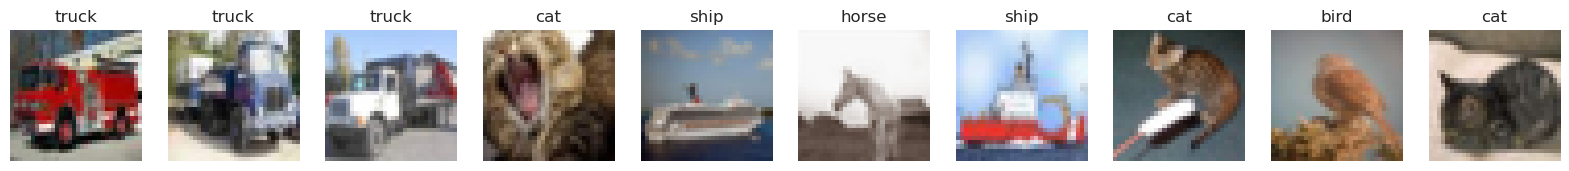

Score: 7


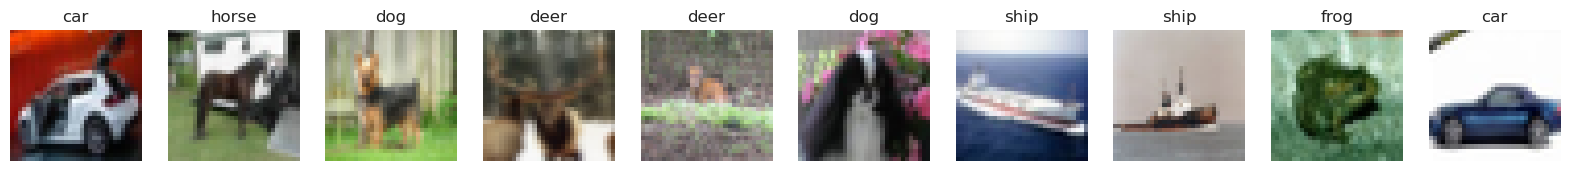

Score: 8


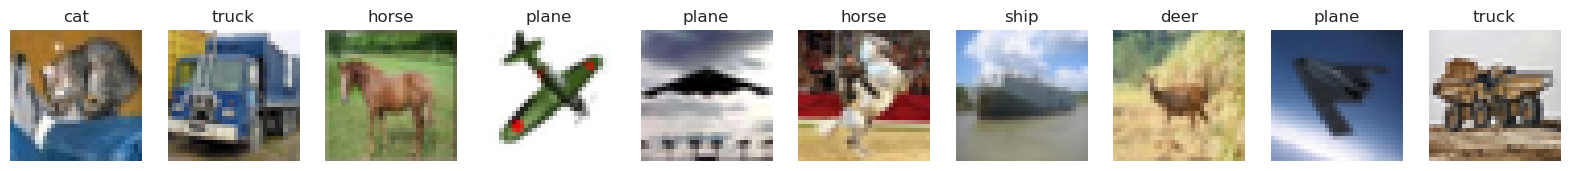

Score: 9


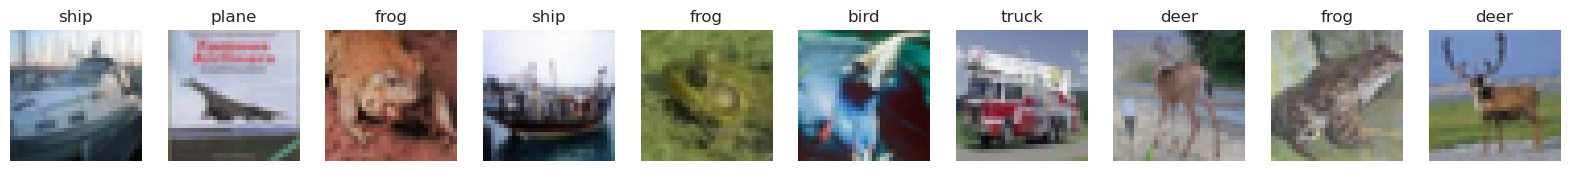

Score: 10


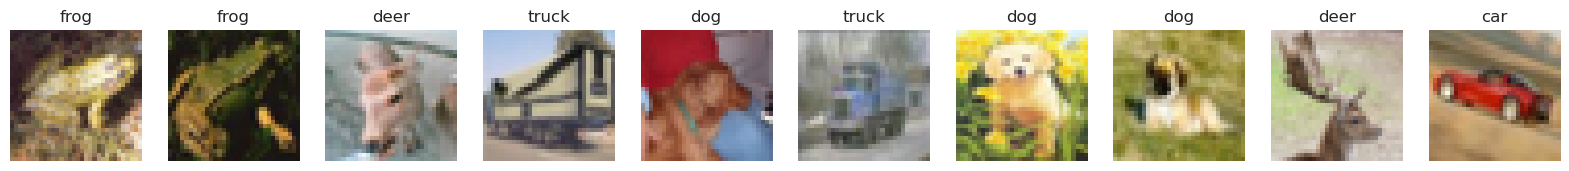

Score: 11


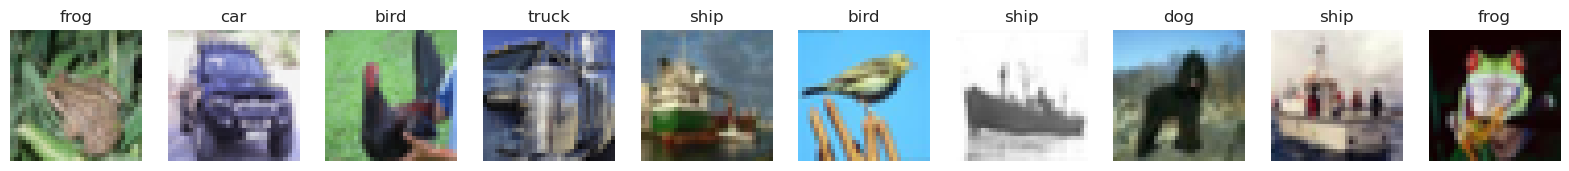

Score: 12


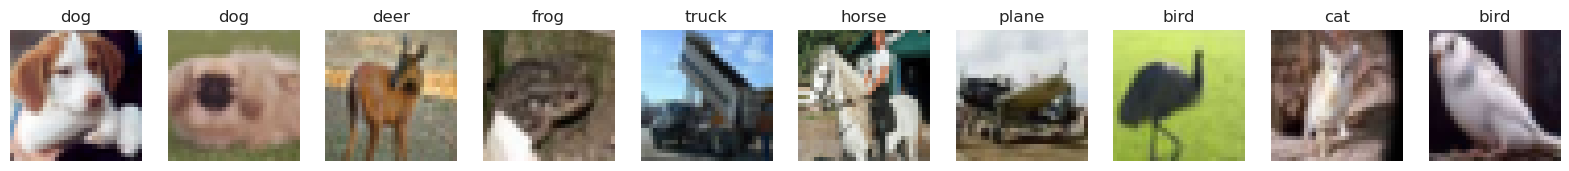

Score: 13


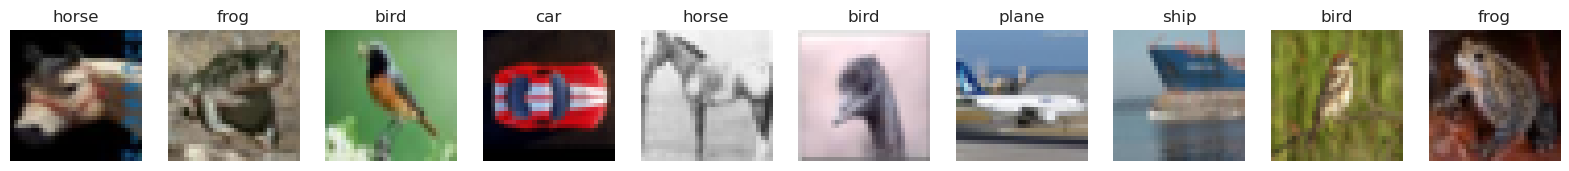

Score: 14


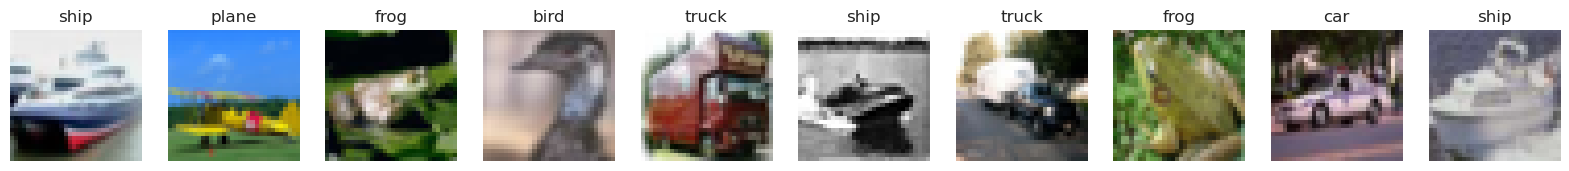

Score: 15


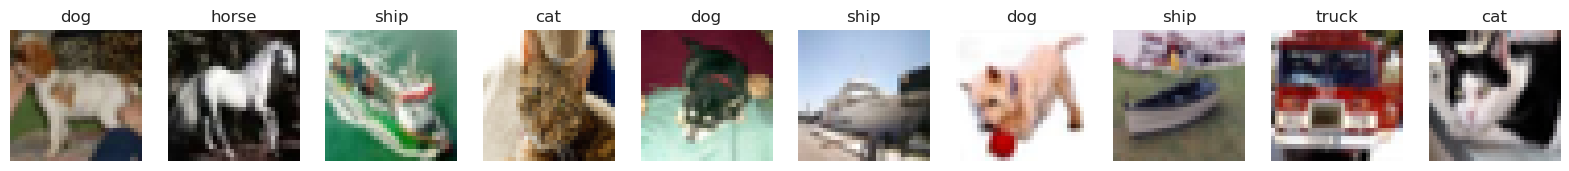

Score: 16


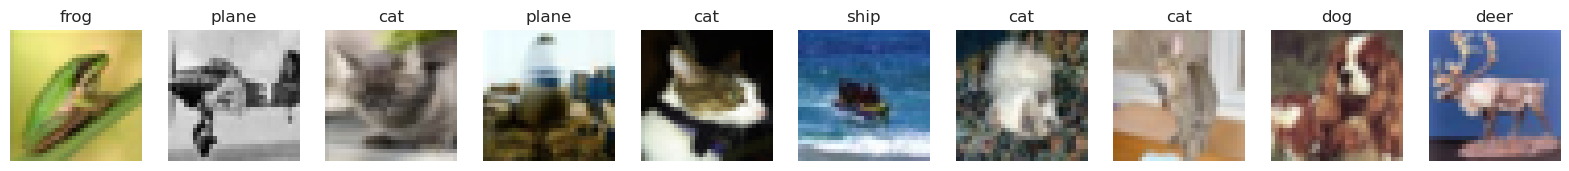

Score: 17


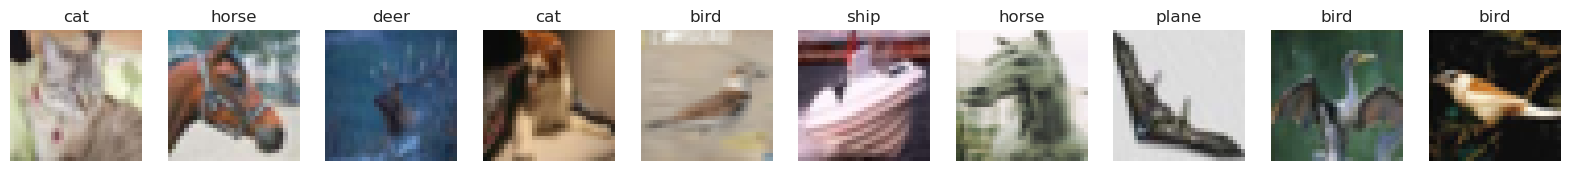

Score: 18


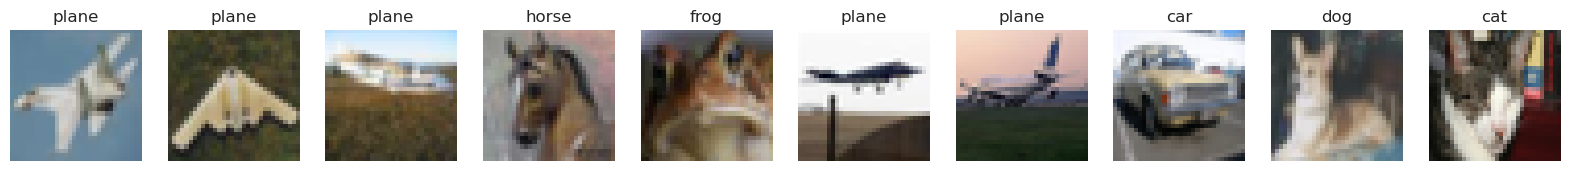

Score: 19


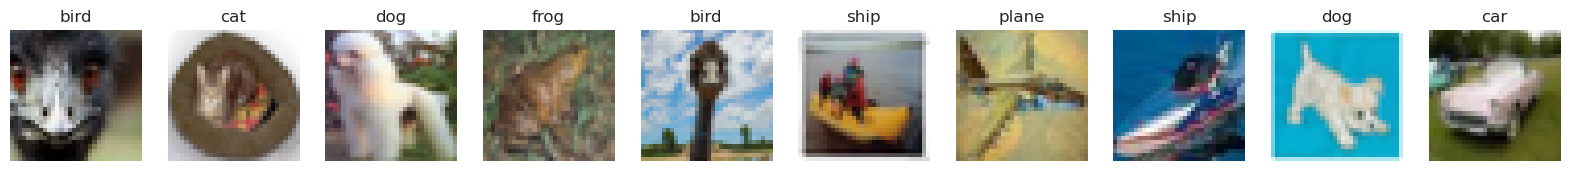

Score: 20


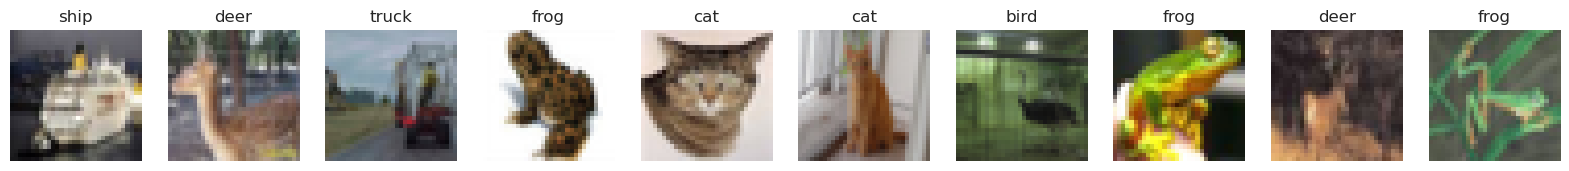

Score: 21


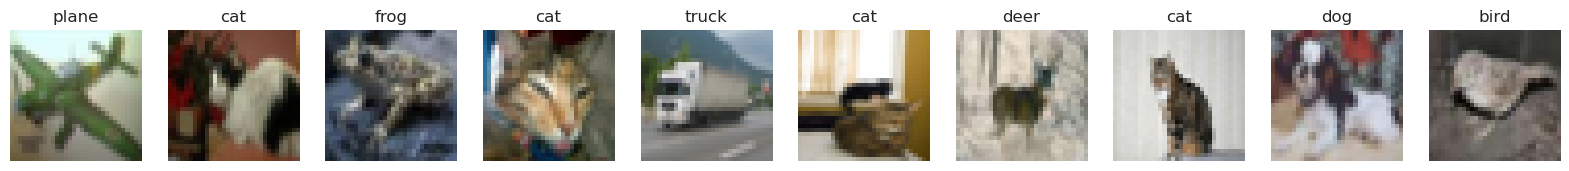

Score: 22


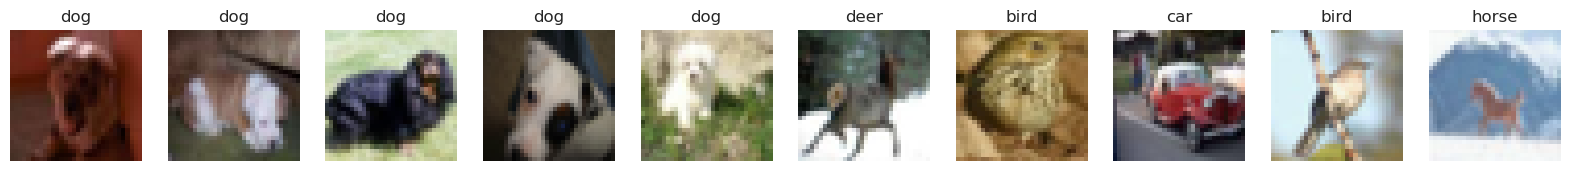

Score: 23


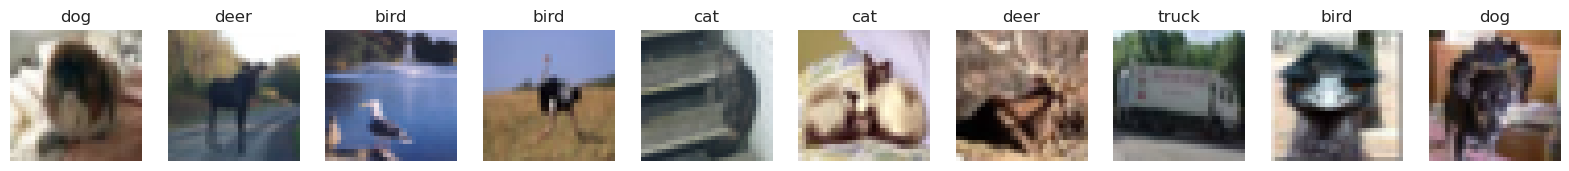

Score: 24


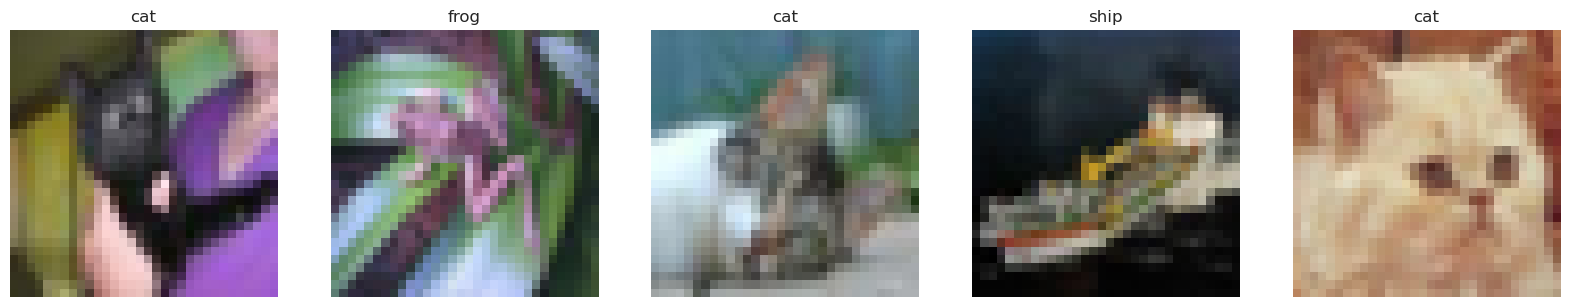

Score: 25


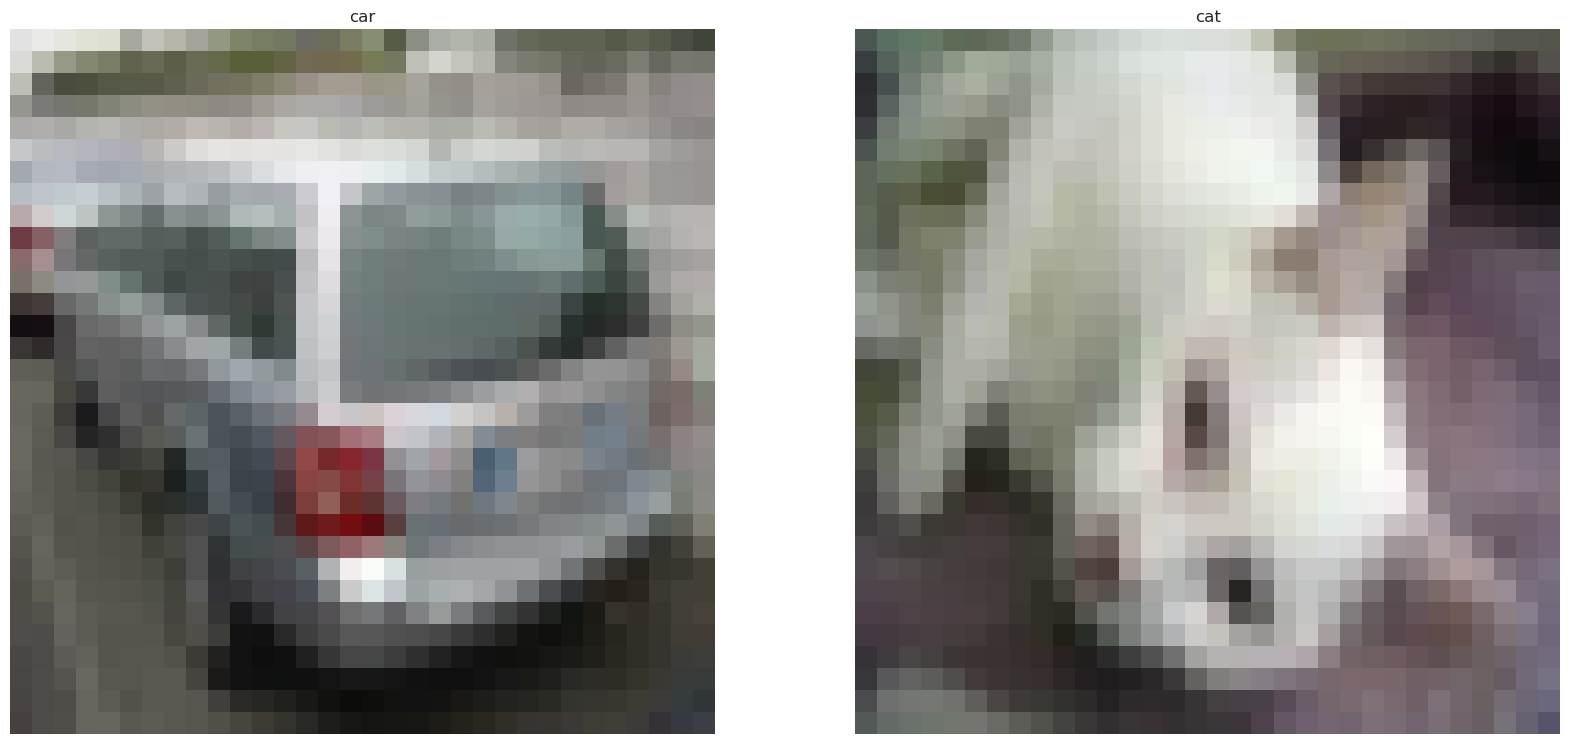

In [19]:
# Visualisation of the iteration learned of CIFAR-10, we grab 10 images for each score after scaled
scaled_img_IL_dict = {}
for key, (img, score, index) in learned_img_IL_dict.items():
    scaled_img_IL_dict[key] = (img, round(score/10), index)
max_score = max([score for (_, score, _) in scaled_img_IL_dict.values()])
min_score = min([score for (_, score, _) in scaled_img_IL_dict.values()])
images_per_score = [[] for _ in range(max_score + 1)]
for img, (target, score, index) in scaled_img_IL_dict.items():
    images_per_score[score].append((img, target, index)) if len(images_per_score[score]) < 10 else None

target_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for score, images in enumerate(images_per_score):
    if len(images) == 0:
        continue
    print(f"Score: {score+1}")
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    for i, (img, target, index) in enumerate(images):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(target_names[target])
        axes[i].axis('off')
    plt.show()

In [20]:
# plotting 10 never learned images in unlearned_il_dict
if len(unlearned_il_dict) < 10:
    print("There are less than 10 unlearned images")
else:
    ten_unlearned_images = list(unlearned_il_dict.items())[:10]
    fig, axes = plt.subplots(1, len(ten_unlearned_images), figsize=(20, 20))
    for i, (img, (target, score, index)) in enumerate(ten_unlearned_images):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(target_names[target])
        axes[i].axis('off')
    plt.show()

There are less than 10 unlearned images


# Compare Iteration Learned with Prediction Depth

In [21]:
def read_pd_files(directory: str) -> tuple[list[str], list[dict]]:
    """
    This function is going to read all .pkl file from a give directory
    @param directory: ..
    @return: ([file name list], [dict list])
    """
    pd_dict_list = []
    file_list = os.listdir(directory)
    pkl_files = [file for file in file_list if file.endswith(".pkl")]

    for pkl_file in pkl_files:
        file_path = os.path.join(directory, pkl_file)
        with open(file_path, "rb") as f:
            dict_load = json.load(f)

            for i in dict_load.keys():
                dict_load[i] = dict_load[i][0] # list of 1 int -> int

            pd_dict_list.append(dict_load)

    return pkl_files, pd_dict_list


pd_result_dir = os.path.join(os.getcwd(), "cl_results_single") # change the second argument to specify the result file
file_name_list, pd_dicts = read_pd_files(pd_result_dir)
number_of_pd_result = len(pd_dicts)
pd_avg_dict = {}

# calculate the average of all pd_dict
for pd_dict in pd_dicts:
    for i in pd_dict.keys():
        pd_avg_dict[int(i)] = pd_avg_dict.get(int(i)) + pd_dict[i] if (int(i) in pd_avg_dict.keys()) else pd_dict[i]
for i in pd_avg_dict:
    pd_avg_dict[i] = round((pd_avg_dict[i])/number_of_pd_result)

FileNotFoundError: [Errno 2] No such file or directory: '/home/eliwang2332/Documents/GitHub/iteration-learned-batched/iteration-learned/cl_results_single'

In [ ]:
import seaborn as sns

imgPD_dict = imgHardnessLink(CIFAR_dict, pd_avg_dict)
imgIL_dict = imgHardnessLink(CIFAR_dict, il_dict)

# relabel all -1 (unlearned) example to 10
il_dict_all = {}
for key, (img, score, index) in imgIL_dict.items():
    if score == -1:
        il_dict_all[key] = (img, 10, index)
    else:
        il_dict_all[key] = (img, round(score/10), index) # divide 10 because we know the max score is 80

common_keys = set(imgPD_dict.keys()).intersection(il_dict_all.keys())

score_il = []
score_pd = []
for key in common_keys:
    score_il.append(il_dict_all[key][1])
    score_pd.append(imgPD_dict[key][1])

sns.regplot(x=score_il, y=score_pd, scatter_kws={"color": "blue", "alpha": 0.3}, line_kws={"color": "red"})
plt.xlabel("Iteration Learned")
plt.ylabel("Prediction Depth")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
